# Numerical exercises 12
_____________________



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.datasets import mnist

import matplotlib.style as style 
style.use('tableau-colorblind10')



## Exercise 12.1: Recognizing hand-written digits with DNN
__________________

In this exercise we will experiment with a **Deep Neural Network** trained on the `minst` database. We will train the deep neural network model to recognize the 10 hand written digits. The data in the database are `.png` images of $28 \times 28$ pixels. Every pixel can assume a scalar value from $0$ (white) to $256$ (black). To each datapoint (an image) has to be assigned a category (one of the $10$ digits). It is a **classification problem**.

We will now load and format the data downloaded from the web. Then we will convert the $X$ datas in matrices and the labels in 10-dimentional vectors: one for each of the possible digits.

Again, we will use the `Sequential()` model. As an activation function, we take the `relu` for the hidden layers but we set the output layer to be activated with `softmax`, which converts a vector of values to a probability distribution, in our case corresponding to the probability distributions for each of the digits. 

As optimizer we will try out:
- Stochastic Gradient Descent (SDG);
- Adam;
- Adadelta.

We will try out the model and calculate accuracy and loss.

Let's start with SDG.

In [21]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [22]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [23]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [24]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

def compile_model(opt):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

def train_model(opt):
    model = compile_model(opt)
    history = model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=epochs,
          verbose=0, shuffle=True,   
          validation_data=(X_test, Y_test))
    return model, history

Model architecture created successfully!
Model compiled successfully and ready to be trained.


In [25]:
batch_size = 32; 
epochs = 10;

model, history = train_model(SGD())

In [37]:
def plot_perf(model):
    score = model.evaluate(X_test, Y_test, verbose=1)
    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

def plot_hist(history):
    plt.figure(figsize=(15,4)); sub=1
    for fc in ('accuracy','loss'):
        plt.subplot(1,2,sub)
        plt.plot(history.history[fc])
        plt.plot(history.history['val_'+fc])
        plt.ylabel('model '+fc)
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['train', 'test'], loc='best')
        sub+=1
    plt.show()

313/313 [==============================] - 1s 2ms/step - loss: 0.1089 - accuracy: 0.9654

Test loss: 0.10888756066560745
Test accuracy: 0.965399980545044


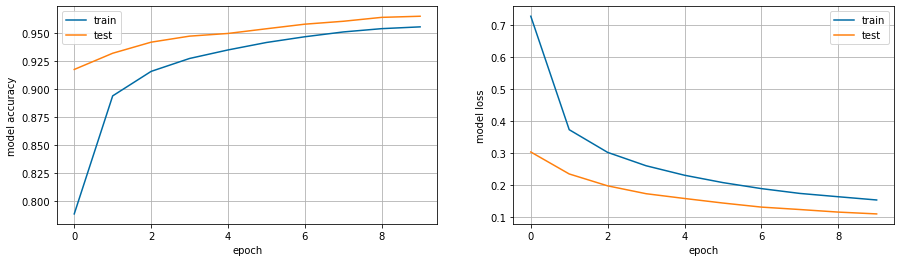

In [38]:
plot_perf(model)
plot_hist(history)

In [28]:
def predictions(model):
    pred = model.predict(X_test)

    X_test_ = X_test.reshape(X_test.shape[0], img_rows, img_cols)
    plt.figure(figsize=(15, 15)) 
    for i in range(10):    
        ax = plt.subplot(1, 10, i + 1)    
        plt.imshow(X_test_[i, :, :], cmap='gray')    
        plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(pred[i])))    
        plt.axis('off') 
    plt.show()

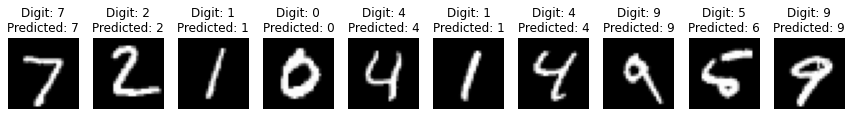

In [29]:
predictions(model)

### Comment on the results with SGD: test error lower than training error

The accuracy is very high, and the model was able to guess $9/10$ digits. The example with the $5$ digit is also very unclear. At the same time we would like to probe the performance of our DNN on completely unknown datas, not part of the `minst`. As far as we can tell, the loss results are promising: the test error is consistently below the training error. This could mean that we are avoiding overfitting.

Now we change optimizer: we are going to use Adam.

In [30]:
model_adam, history_adam = train_model(Adam())

313/313 [==============================] - 1s 2ms/step - loss: 0.0746 - accuracy: 0.9838

Test loss: 0.07461535930633545
Test accuracy: 0.9837999939918518


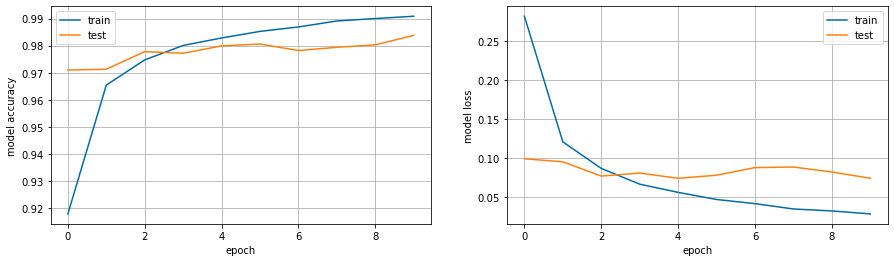

In [39]:
plot_perf(model_adam)
plot_hist(history_adam)

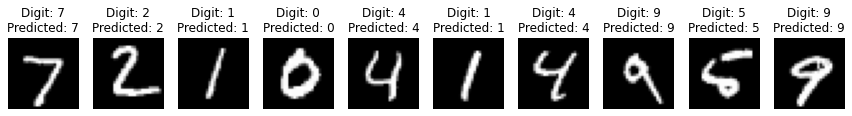

In [32]:
predictions(model_adam)

### Comments on the results with Adam: possible overfit?

Here we have very high accuracy but the test error is higher than the training error. This could mean that the model is overfitting the datas. The predictions are all correct though, including the one with the horribly written $5$.

Now let's try out Adadelta.

In [34]:
model_del, history_del = train_model(Adadelta())

313/313 [==============================] - 1s 2ms/step - loss: 0.9216 - accuracy: 0.8351

Test loss: 0.9216432571411133
Test accuracy: 0.835099995136261


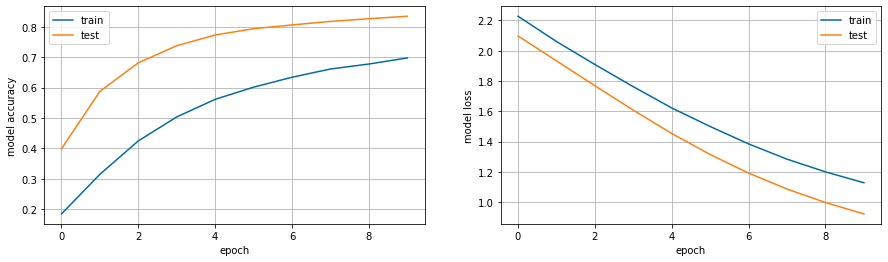

In [40]:
plot_perf(model_del)
plot_hist(history_del)

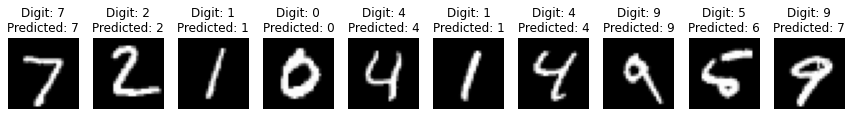

In [36]:
predictions(model_del)

Here the results are very disappointing: The accuracy is lower than in the two previous cases and we are clearly witnessing to overfitting, and from very early epochs. 


## Exercise 12.2: Recognizing hand-written digits with CNN
________________

We will now try a different architecture: the **CNN, Convolutional Neural Network**, a _translationally invariant_ neural network that respects locality of the input data. This should work better because coarse graining operations implemented by this kind of networks. 

As a first step we reshape the datas to work them out with CNN. Then we create & compile the model and we evaluate its performance.

In [41]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [42]:
def create_CNN():
    # instantiate model
    model = Sequential([
    # layer with 10 filters (dimensionality of output space)
    keras.layers.Conv2D(10, kernel_size=(5, 5), 
                        input_shape=input_shape, 
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    # soft-max layer
    keras.layers.Dense(num_classes, activation='softmax')
    ])
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['accuracy'])
    return model

In [44]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

313/313 [==============================] - 1s 4ms/step - loss: 0.0553 - accuracy: 0.9815

Test loss: 0.055339012295007706
Test accuracy: 0.9815000295639038


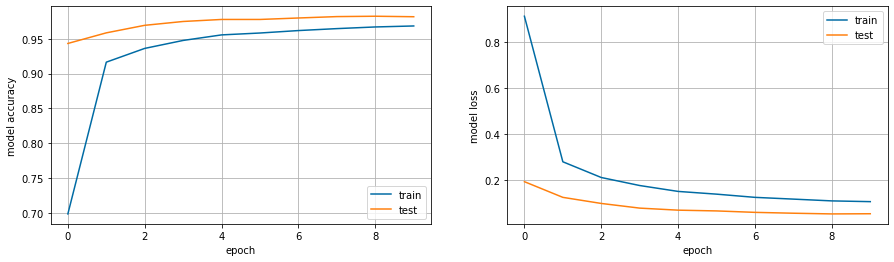

In [45]:
plot_perf(model_CNN)
plot_hist(history)

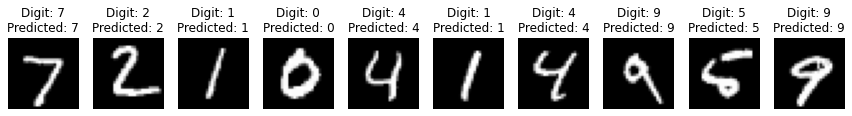

In [46]:
predictions(model_CNN)

### Comments on the results: the best obtained

The results obtained are the best: the test error is always smaller than the training error and the test accuracy is very high, with $98 \%$. In the example all of the digits where correctly classified. It seems to be working well.


## Exercise 12.3: Let's try out with my digits
_______________________________

Now, thanks to the use of `gimp` to draw the ten digits, we will test our CNN net and my hand writing. My hand written digits are the following:

In [61]:
for k in range(10):
    digit_filename = str(k)+'.png'
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255

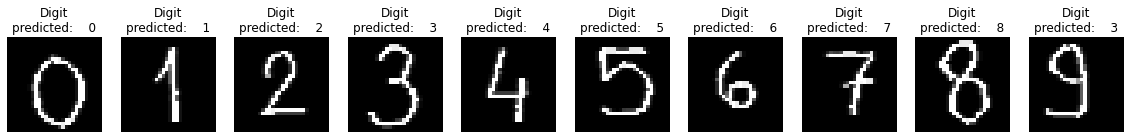

In [64]:
plt.figure(figsize=(20, 3))  
for k in range(10):
    digit_filename = str(k)+'.png'
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255


    data = data.reshape(1,xdim,ydim,1)
    pred_0 = model_CNN.predict(data)

    data = data.reshape(xdim,ydim)

    plt.subplot(1,10,k+1)
    plt.imshow(data, cmap='gray')    
    plt.title("Digit\npredicted:    {}".format(np.argmax(pred_0)))
    plt.axis('off') 
plt.show()

### Comments on the results: it works (more or less)

The performance is satisfying, we can say that the CNN has a good predictive power.